# MaskDetection API 정확도 테스트 

1. face detection 으로 얼굴만 캡처 mask detection 으로 이미지 전송

2. mask detection 으로 예측된 score 반환


## 1. face detection accuracy 

### face detection without mask
100%

### face detection with mask

55.148005148005154%

다음 이미지들과 같이 화질이 안좋거나 정면에서 찍은 사진이 아닌 이미지가 다수 포함되어 있기 때문


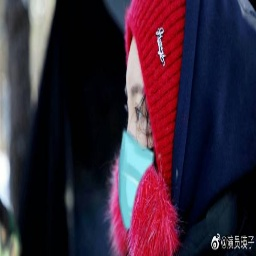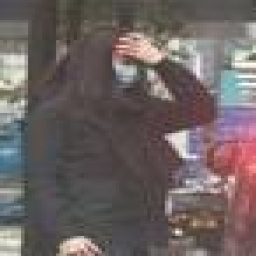

## 2. mask detection accuracy

In [162]:
import os
print(os.environ['PATH'])

/Users/dongcheoljwa/torch/install/bin:/Users/dongcheoljwa/.nvm/versions/node/v13.11.0/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Users/dongcheoljwa/torch/install/bin:/Users/dongcheoljwa/.nvm/versions/node/v13.11.0/bin


In [143]:
from PIL import Image, ImageOps
import numpy as np

import tensorflow.keras
import argparse
import json
import pandas
import seaborn as sns
import os

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = tensorflow.keras.models.load_model('../py/keras_model.h5', compile=False)

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
# Replace this with the path to your image
accuracy_score_masked= []
accuracy_score= []
ismasked = []


In [144]:
for root, dirs, files in os.walk('../mask/out/', topdown=False):
    for name in files:
        image_path = os.path.join(root, name)
        if("masked" in name):
            ismasked.append(True)
        else :
            ismasked.append(False)
        image= Image.open(image_path)
        #resize the image to a 224x224 with the same strategy as in TM2:
        #resizing the image to be at least 224x224 and then cropping from the center
        size = (224, 224)
        image = ImageOps.fit(image, size, Image.ANTIALIAS)

        #turn the image into a numpy array
        image_array = np.asarray(image)

        # display the resized image
        # image.show()

        # Normalize the image
        normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

        # Load the image into the array
        data[0] = normalized_image_array

        # run the inference
        prediction = model.predict(data)
        accuracy_score.append(round(prediction[0][0],10))
        accuracy_score_masked.append(round(prediction[0][1],10))


In [145]:

import pandas as pd
df= pd.DataFrame()
df['ismasked']= ismasked
df['accuracy_score'] = accuracy_score
df['accuracy_score_masked'] = accuracy_score_masked



### df 속성 설명

마스크 속성은 true false 두가지로 분류됩니다.
true일 경우 마스크 착용된 이미지라는 의미이고 false 일 경우 마스크를 착용하지 않은 이미지입니다.

accuracy_score 속성은 모델이 예측한 정확도입니다. 1에 가까울 수록 마스크를 쓰지 않았다고 predict한 것입니다.
반대로 accuracy_score_masked 속성은 1에 가까울 수록 마스크를 썼다고 예측한 정확도입니다.

마스크를 쓰지 않은 이미지 1766
마스크를 쓴 이미지 1704

In [146]:
df['ismasked'].describe()

count      3480
unique        2
top       False
freq       1766
Name: ismasked, dtype: object

In [147]:
df[df.ismasked==False]['ismasked'].describe()

count      1766
unique        1
top       False
freq       1766
Name: ismasked, dtype: object

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ismasked               3480 non-null   bool   
 1   accuracy_score         3480 non-null   float64
 2   accuracy_score_masked  3480 non-null   float64
dtypes: bool(1), float64(2)
memory usage: 57.9 KB


## 마스크 미착용 예측률


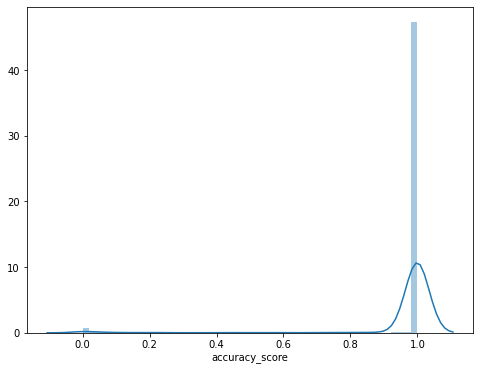

In [149]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df[df.ismasked==0]['accuracy_score'])

## 마스크 착용 예측률


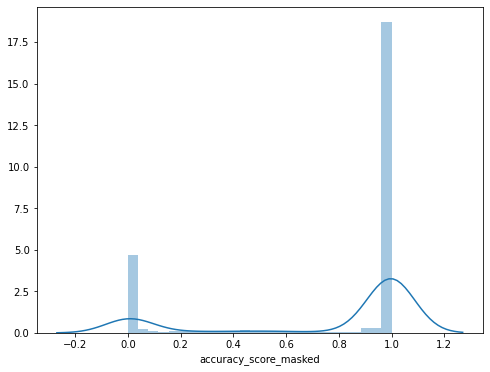

In [150]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df[df.ismasked==1]['accuracy_score_masked'])

In [154]:
true_n= len(df[df.ismasked==False][df.accuracy_score>0.9])
false_p =len(df[df.ismasked==False][df.accuracy_score<0.1])
t_f=[true_n,false_p]
false_n = len(df[df.ismasked==True][df.accuracy_score>0.9])
true_p =len(df[df.ismasked==True][df.accuracy_score<0.1])
t_f1=[false_n,true_p]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


임계값 0.9 
데이터 예측 특성상 0.1~0.9 의 비율이 현저하게 적음 

## 오차 행렬 및 정확도 분석

In [155]:
print(t_f)
print(t_f1)

[1689, 37]
[329, 1264]


In [156]:
## precision score
precision = true_p/(true_p+false_p)
print(precision)

0.9715603382013835


In [157]:
## recall score
recall = true_p/(true_p+false_n)
print(recall)

0.7934714375392341


In [158]:
## F1 score
2/(1/precision+1/recall)

0.8735314443676572

정밀도 0.97

재현율 0.79

F1 score 0.87



In [159]:
from matplotlib import pyplot as plt
%matplotlib inline


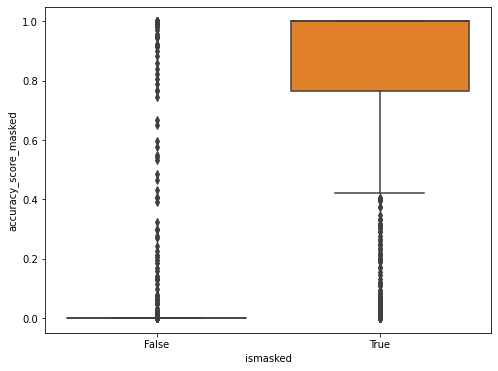

In [160]:

data = pd.concat([df['ismasked'], df['accuracy_score_masked']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='ismasked', y="accuracy_score_masked", data=data)

### 문제점
1. mask 이미지에서 face detection 성능이 좋지 않다 (58%)
    - 정면 및 화질 좋은 마스크 이미지로 다시 테스트?
2. mask detection 성능이 좋지 않다 
    - teachable machine 대신 새로운 모델로 트레이닝 
    - test용 데이터 셋이 좋지 못함 ex) 사람이 다수 촬영된 경우 메인이 마스크를 썼더라도 주변 마스크를 안쓴 얼굴이 캡처됨